<a href="https://colab.research.google.com/github/surajK610/AI/blob/master/Book_Classification_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install python_louvain
!pip install torch_geometric

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import os
import networkx as nx
import community as community_louvain

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import SpectralEmbedding
from scipy.stats import entropy, mode, zscore

import torch

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import tqdm

import warnings

from itertools import chain

style.use('ggplot')
warnings.filterwarnings(action='ignore')

In [ ]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/My Drive/'

node_path = os.path.join(gdrive_path, 'anon_nodes_2k.csv')
edge_path = os.path.join(gdrive_path, 'anon_edges_2k.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
nodes = pd.read_csv(node_path)
edges = pd.read_csv(edge_path)

# **Exploratory Data Analysis**

### Graph Visualization

In [ ]:
def create_graph(edges):
  G = nx.from_pandas_edgelist(edges, 'Book', 'Customer')
  return G


def plot_graph(edges, nodes):
    G = create_graph(edges)
    return _plot_graph(G, nodes)

def _plot_graph(G, nodes):
  pos = nx.spring_layout(G)

  classes = nodes.Category.unique()
  colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#aec7e8', '#ffbb78']
  class_color = dict(zip(classes, colors))

  shape_symbol = {False: 'circle', True: 'cross'}

  node_x = []
  node_y = []
  node_color, node_shape = [], []
  for node in G.nodes():
      x, y = pos[node]
      node_x.append(x)
      node_y.append(y)
      if node in nodes['ID'].tolist():
        category = (nodes[nodes['ID'] == node].iloc[0].Category)
        fake = (nodes[nodes['ID'] == node].iloc[0].isFake)
        node_color.append(class_color[category])
        node_shape.append(shape_symbol[fake])
      else:
        node_color.append('black')
        node_shape.append('square')

  edge_x = []
  edge_y = []
  for edge in G.edges():
      x0, y0 = pos[edge[0]]
      x1, y1 = pos[edge[1]]
      edge_x.append(x0)
      edge_x.append(x1)
      edge_y.append(y0)
      edge_y.append(y1)

  edge_trace = go.Scatter(
      x=edge_x, y=edge_y,
      line=dict(width=0.5, color='#888'),
      hoverinfo='none',
      mode='lines')

  node_trace = go.Scatter(
      x=node_x, y=node_y,
      mode='markers',
      hoverinfo='text',
      marker=dict(
        showscale=True,
        colorscale='Viridis',
        size=10,
        color=node_color,
        symbol=node_shape,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right')
    )
  )

  node_trace['text'] = ()
  for node in G.nodes():
      x, y = pos[node]
      if node in nodes['ID'].tolist():
        category = (nodes[nodes['ID'] == node].iloc[0].Category)
        fake =  'Fake' if (nodes[nodes['ID'] == node].iloc[0].isFake) else 'Real'
        node_trace['text'] += (f'Cat {category}, {fake}',)
      else:
        node_trace['text'] += ('Unknown',)

  fig = go.Figure(data=[edge_trace, node_trace],
              layout=go.Layout(
                  showlegend=False,
                  hovermode='closest',
                  margin=dict(b=0,l=0,r=0,t=0),
                  xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                  )
  fig.show()
  return G, fig

In [ ]:
G, fig = plot_graph(edges, nodes)

**Observations**
1. Looks like similar groups are located close to each other in the graph.
(can do some basic clustering to get a naive baseline to describe the data)

2. Looks like fake customers have a far more random distribution, and thus are connected to far more types of groups (can use some sort of distribution statistical analysis to filter potentially)

3. Different distribution of values


### Distribution Statistics

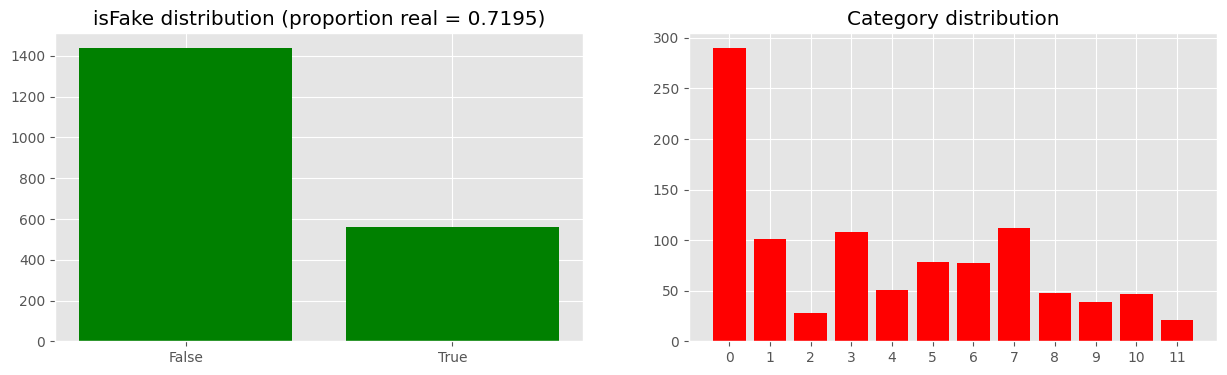

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

## isFake distribution
bar_counts = nodes['isFake'].value_counts()
ax1.bar([str(val) for val in bar_counts.index], bar_counts, color='g')
_ = ax1.set_title(f'isFake distribution (proportion real = {bar_counts.loc[False]/bar_counts.sum()})')

## Category distribution
bar_counts = nodes['Category'].value_counts().drop(-1)
bar_counts = bar_counts.sort_index()
ax2.bar([str(val) for val in bar_counts.index], bar_counts, color='r')
_ = ax2.set_title(f'Category distribution')

In [ ]:
def plot_customer(cust_id):
  booklist_cust = edges[edges['Customer'] == cust_id]
  booklist_cust = nodes[nodes['ID'].isin(booklist_cust['Book'])]

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 2))

  fake_counts = booklist_cust['isFake'].value_counts()
  fake_counts_index = ['Fake' if val else 'Real' for val in fake_counts.index]
  ax1.bar(fake_counts_index, fake_counts, color='g')
  ax1.set_title(f'book neighbor distribution (proportion real = {fake_counts.loc[False]/fake_counts.sum():.2f})')

  cat_counts = booklist_cust['Category'].value_counts()
  cat_counts = cat_counts.sort_index()
  ax2.bar([str(val) for val in cat_counts.index], cat_counts, color='r')
  ax2.set_title(f'Category distribution')

  return ax1, ax2


### Fake Customer Distributions

In [ ]:
nodes[(nodes['Type'] == 'Customer') & (nodes['isFake'] == True)].sample(3)

,ID,Type,isFake,Category
1520,101520,Customer,True,-1
487,100487,Customer,True,-1
328,100328,Customer,True,-1


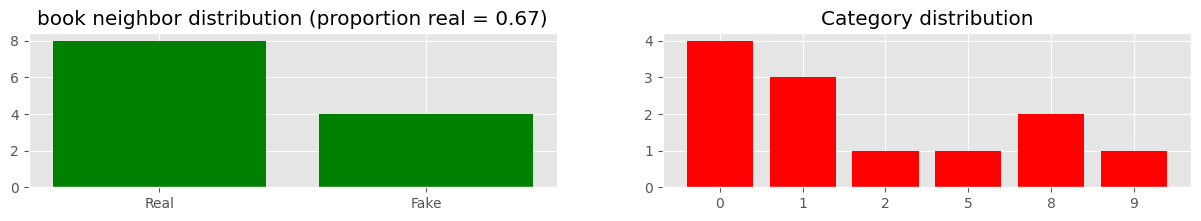

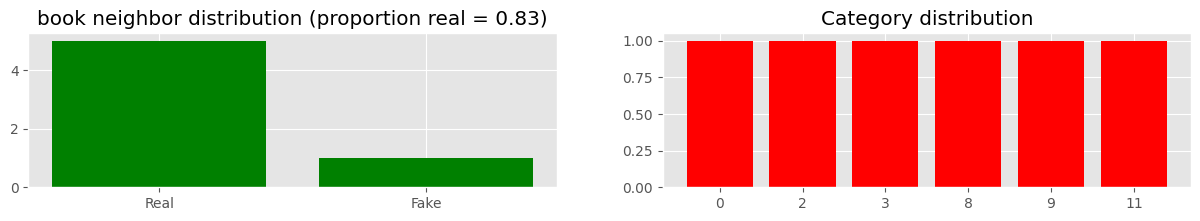

In [ ]:
## Fake Customer Examples [ID = 100030]
_, _ = plot_customer(100030)

## FakeCustomer Examples [ID = 101138]
_, _ = plot_customer(101138)

# ## Fake Customer Examples [ID = 101682]
# _, _ = plot_customer(101682)


### Real Customer Distributions

In [ ]:
nodes[(nodes['Type'] == 'Customer') & (nodes['isFake'] == False)].sample(3)

,ID,Type,isFake,Category
818,100818,Customer,False,-1
1729,101729,Customer,False,-1
96,100096,Customer,False,-1


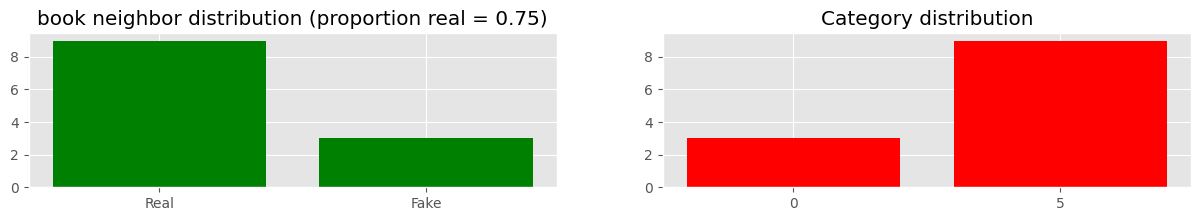

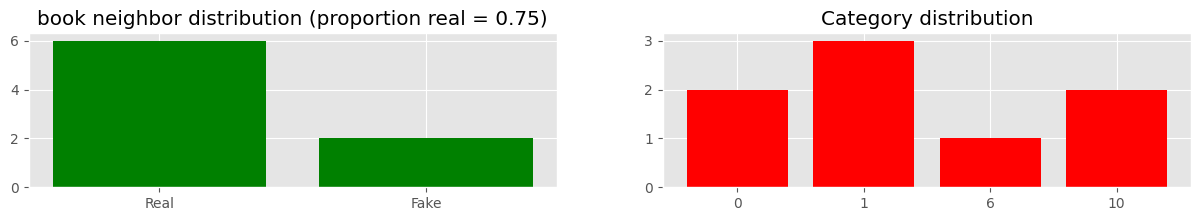

In [ ]:
## Real Customer Examples [ID = 101264]
_, _ = plot_customer(101264)

## Real Customer Examples [ID = 101545]
_, _ = plot_customer(101545)

# ## Real Customer Examples [ID = 101979]
# _, _ = plot_customer(101979)


### Fake vs. Real Customer Distributional Differences

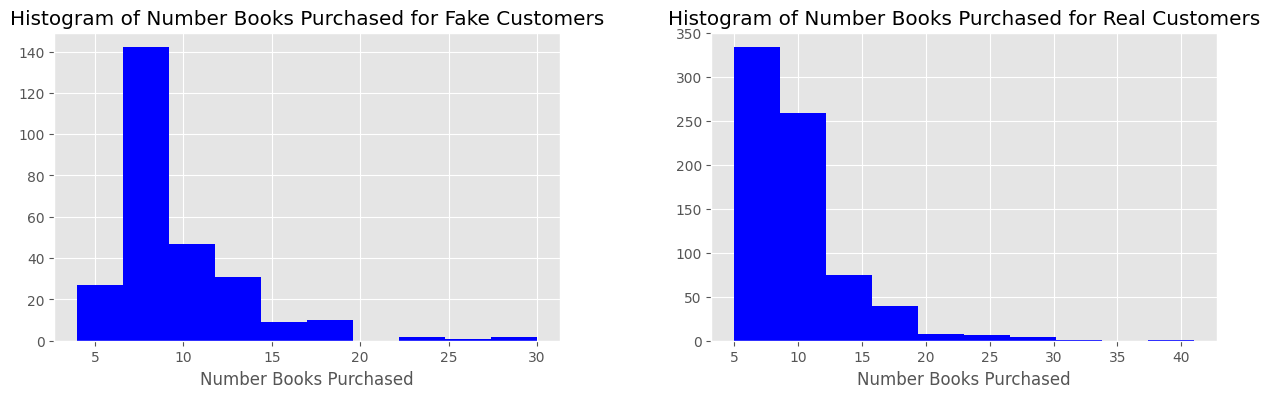

In [ ]:
## Avg Number Neighbors Fake vs. Real Customers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

fake_customers = nodes[(nodes['Type'] == 'Customer') & (nodes['isFake'] == True)]['ID']
edges[edges['Customer'].isin(fake_customers)].groupby('Customer').count().hist(ax=ax1, color='blue')
ax1.set_xlabel('Number Books Purchased')
ax1.set_title('Histogram of Number Books Purchased for Fake Customers')

real_customers = nodes[(nodes['Type'] == 'Customer') & (nodes['isFake'] == False)]['ID']
edges[edges['Customer'].isin(real_customers)].groupby('Customer').count().hist(ax=ax2, color='blue')
ax2.set_xlabel('Number Books Purchased')
_ = ax2.set_title('Histogram of Number Books Purchased for Real Customers')


In [ ]:
def unique_categories(list_books):
  return nodes[nodes['ID'].isin(list_books[0])]['Category'].nunique()

def unique_categories_real(list_books):
  return nodes[(nodes['ID'].isin(list_books[0])) & (nodes['Category']  != 0)]['Category'].nunique()

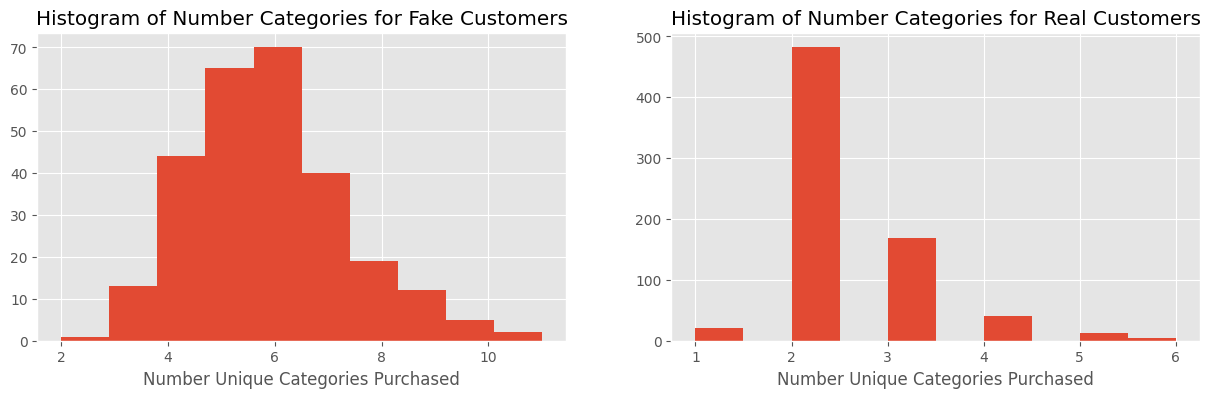

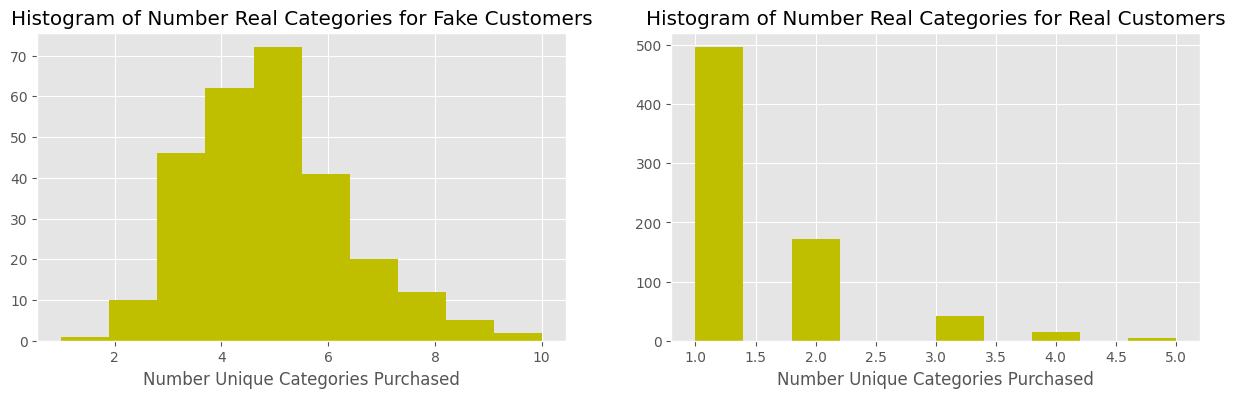

In [ ]:
## Avg Number Unique Categories of Neighbors Fake vs. Real Customers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

fake_customers = nodes[(nodes['Type'] == 'Customer') & (nodes['isFake'] == True)]['ID']
edges[edges['Customer'].isin(fake_customers)].groupby('Customer').agg(list).apply(unique_categories, axis=1).hist(ax=ax1)
ax1.set_xlabel('Number Unique Categories Purchased')
ax1.set_title('Histogram of Number Categories for Fake Customers')

real_customers = nodes[(nodes['Type'] == 'Customer') & (nodes['isFake'] == False)]['ID']
edges[edges['Customer'].isin(real_customers)].groupby('Customer').agg(list).apply(unique_categories, axis=1).hist(ax=ax2)
ax2.set_xlabel('Number Unique Categories Purchased')
_ = ax2.set_title('Histogram of Number Categories for Real Customers')

## Avg Number Unique Categories of Neighbors Fake vs. Real Customers (Without Fake Books)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

fake_customers = nodes[(nodes['Type'] == 'Customer') & (nodes['isFake'] == True)]['ID']
edges[edges['Customer'].isin(fake_customers)].groupby('Customer').agg(list).apply(unique_categories_real, axis=1).hist(ax=ax1, color='y')
ax1.set_xlabel('Number Unique Categories Purchased')
ax1.set_title('Histogram of Number Real Categories for Fake Customers')

real_customers = nodes[(nodes['Type'] == 'Customer') & (nodes['isFake'] == False)]['ID']
edges[edges['Customer'].isin(real_customers)].groupby('Customer').agg(list).apply(unique_categories_real, axis=1).hist(ax=ax2, color='y')
ax2.set_xlabel('Number Unique Categories Purchased')
_ = ax2.set_title('Histogram of Number Real Categories for Real Customers')


**Observations**
* Fake Customers have far more categories of books that they purchase on average
* Real Customers have very few unique categories of books that they normally purchase

### Fake vs. Real Book Distributional Differences

In [ ]:
def customers_real(list_customers):
  return nodes[(nodes['ID'].isin(list_customers[0])) & (nodes['isFake']  == False)]['Category'].count()

def customers_fake(list_customers):
  return nodes[(nodes['ID'].isin(list_customers[0])) & (nodes['isFake']  == True)]['Category'].count()

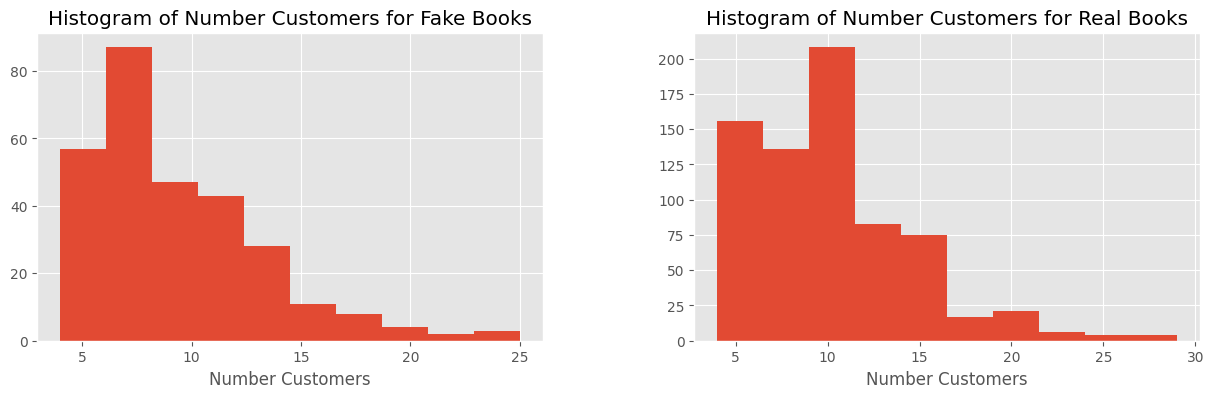

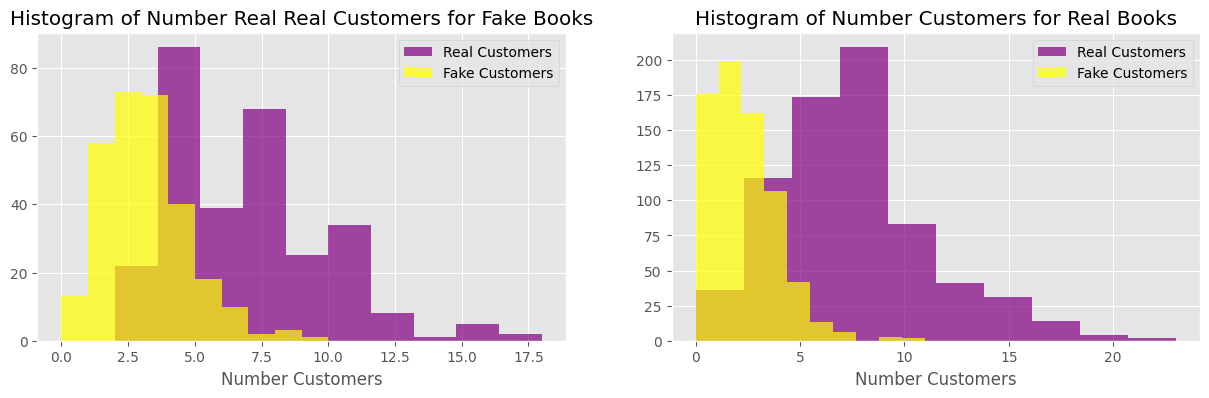

In [ ]:
## Avg Number of Customers Fake vs. Real Books
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

fake_books = nodes[(nodes['Type'] == 'Book') & (nodes['isFake'] == True)]['ID']
edges[edges['Book'].isin(fake_books)].groupby('Book').count().hist(ax=ax1)
ax1.set_xlabel('Number Customers')
ax1.set_title('Histogram of Number Customers for Fake Books')

real_books = nodes[(nodes['Type'] == 'Book') & (nodes['isFake'] == False)]['ID']
edges[edges['Book'].isin(real_books)].groupby('Book').count().hist(ax=ax2)
ax2.set_xlabel('Number Customers')
ax2.set_title('Histogram of Number Customers for Real Books')

## Avg Number of Customers Fake vs. Real Books  (Without Fake Customers)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

fake_books = nodes[(nodes['Type'] == 'Book') & (nodes['isFake'] == True)]['ID']
edges[edges['Book'].isin(fake_books)].groupby('Book').agg(list).apply(customers_real, axis=1).hist(ax=ax1, alpha=0.7, color='purple', label='Real Customers')
edges[edges['Book'].isin(fake_books)].groupby('Book').agg(list).apply(customers_fake, axis=1).hist(ax=ax1, alpha=0.7, color='yellow', label='Fake Customers')
ax1.legend()
ax1.set_xlabel('Number Customers')
ax1.set_title('Histogram of Number Real Real Customers for Fake Books')

real_books = nodes[(nodes['Type'] == 'Book') & (nodes['isFake'] == False)]['ID']
edges[edges['Book'].isin(real_books)].groupby('Book').agg(list).apply(customers_real, axis=1).hist(ax=ax2, alpha=0.7, color='purple', label='Real Customers')
edges[edges['Book'].isin(real_books)].groupby('Book').agg(list).apply(customers_fake, axis=1).hist(ax=ax2, alpha=0.7, color='yellow', label='Fake Customers')
ax2.legend()
ax2.set_xlabel('Number Customers')
_ = ax2.set_title('Histogram of Number Customers for Real Books')


**Observations**
* Looks like it might be difficult to find a clear signal in these graphs
* Seems that there are fewer real customers for fake books than real books, but this is a noisy signal that could not give us a clear way to differentiate


### Fake vs. Real Book Customer Purchasing Differences

In [ ]:
def plot_book_customer(book_id, filter=False, figsize=(15, 4)):
  booklist_cust = edges[edges['Book'] == book_id]['Customer'].tolist()
  if filter:
    booklist_cust = nodes[(nodes['ID'].isin(booklist_cust)) & (nodes['isFake'] == False)]['ID'].tolist()
    ## filters fake customers
  booklist_cust = edges[edges['Customer'].isin(booklist_cust)]['Book'].tolist()
  otherbooks = nodes[nodes['ID'].isin(booklist_cust)]['Category'].value_counts()

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
  fake_counts = otherbooks[0] if 0 in otherbooks.index else 0
  fake_counts = (fake_counts, otherbooks.sum() - fake_counts)
  fake_counts_index = ('Fake', 'Real')
  ax1.bar(fake_counts_index, fake_counts, color='g')
  ax1.set_title(f'Other Bought Books Distribution (proportion real = {fake_counts[1]/otherbooks.sum():.2f})')

  otherbooks = otherbooks.sort_index()
  ax2.bar([str(val) for val in otherbooks.index], otherbooks, color='r')
  ax2.set_title(f'Other Bought Books Category Distribution')

  return ax1, ax2



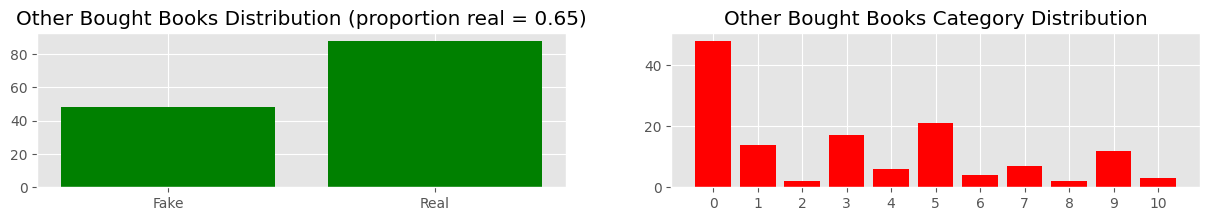

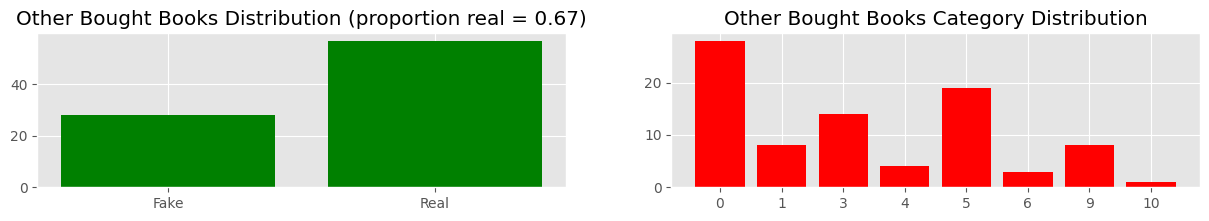

In [ ]:
## Fake Book Examples [ID = 101278]
_, _ = plot_book_customer(101427, figsize=(15, 2))
_, _ = plot_book_customer(101427, filter=True, figsize=(15, 2))

# ## Fake Book Examples [ID = 100815]
# _, _ = plot_book_customer(100815, figsize=(15, 2))
# _, _ = plot_book_customer(100815, filter=True, figsize=(15, 2))

# ## Fake Book Examples [ID = 100983]
# _, _ = plot_book_customer(100983)
# _, _ = plot_book_customer(100983, filter=True, figsize=(15, 2))

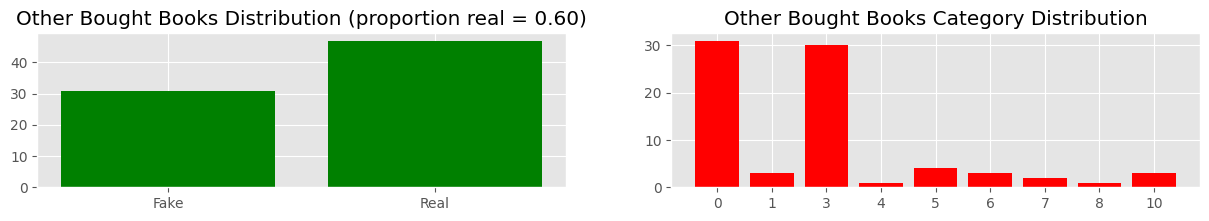

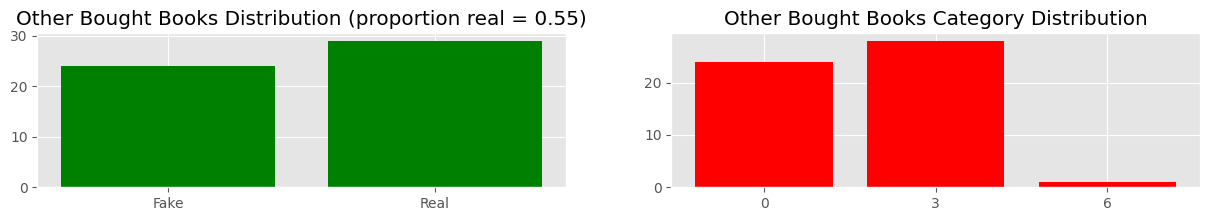

In [ ]:
## Real Book Examples [ID = 11115]
_, _ = plot_book_customer(11115, figsize=(15, 2))
_, _ = plot_book_customer(11115, filter=True, figsize=(15, 2))

# ## Real Book Examples [ID = 10536]
# _, _ = plot_book_customer(10536, figsize=(15, 2))
# _, _ = plot_book_customer(10536, filter=True, figsize=(15, 2))

# ## Real Book Examples [ID = 11149]
# _, _ = plot_book_customer(11149)
# _, _ = plot_book_customer(11149, filter=True, figsize=(15, 2))



**Observations**

* Looks like we can clearly differentiate between real and fake books by distributional differences (fake books have much higher entropy for other bought books by a customer)
* Once we filter out fake customers, this difference becomes even more obvious

# **Solution Development**

## Train Test Split

* Split the data into train and test as a 30-70 split
* Assume per instructions that we know all the edges
* For test set, we do not know the status of the nodes

**Information we Know** \\
*Customer Train*: Know Books Purchased & isFake \\
*Books Train*: Know Category & isFake (Know Customers Purchased) \\
*Customer Test*: Know Books Purchased \\
*Books Test*: (Know Customers Purchased)

In [ ]:
TRAIN_FRAC = 0.30
RANDOM_STATE = 50
customers_train, books_train = nodes[nodes['Type'] == 'Customer'].sample(frac=TRAIN_FRAC, random_state=RANDOM_STATE), nodes[nodes['Type'] == 'Book'].sample(frac=TRAIN_FRAC, random_state=RANDOM_STATE)
customers_test, books_test = nodes[nodes['Type'] == 'Customer'].drop(customers_train.index), nodes[nodes['Type'] == 'Book'].drop(books_train.index)


In [ ]:
G, fig = plot_graph(edges, pd.concat([books_train, customers_train], axis=0))

## Models

### **Strategy 1**
1. Given a particular book, filter customers who have bought this book
2. Calculate the highest proportion known train category book bought from each of these customers - each customer will be represented by this category
3. Each customer has one vote, and the winner of the vote wins

In [ ]:
def get_maj_booktype(cust_id):
  booklist_cust = edges[(edges['Customer'] == cust_id) & (edges['Book'].isin(books_train['ID'].tolist()))]
  ## only know book labels in train set

  booklist_cust = nodes[nodes['ID'].isin(booklist_cust['Book'])]
  if len(booklist_cust['Category']) == 0:
    return np.nan
    ## returns np.nan if no books in train set
  max_val = booklist_cust['Category'].value_counts().index[0]
  if (max_val == 0) and (len(booklist_cust['Category'].value_counts()) > 1): max_val = booklist_cust['Category'].value_counts().index[1]
  # if (entropy(booklist_cust['Category'].value_counts()) > 1.4) or len(booklist_cust['Category'].value_counts()) >= 4: return 0
  return max_val

In [ ]:
customers_per_test_book = edges[(edges['Book'].isin(books_test['ID'].tolist()))]
customers_per_test_book['Maj_Category'] = customers_per_test_book['Customer'].apply(get_maj_booktype)

In [ ]:
predictions = customers_per_test_book[['Book', 'Maj_Category']].groupby('Book').agg(pd.Series.mode)
predictions = predictions.reset_index()
predictions = predictions.merge(books_test[['ID', 'Category']], left_on='Book', right_on='ID', how='inner')

In [ ]:
pred_corr = lambda row: any(row['Maj_Category'] in row['Category']) if type(row['Category']) == np.ndarray else (row['Maj_Category'] == row['Category'])
predictions['Correct'] = predictions.apply(pred_corr, axis=1)
predictions['Correct'] = predictions['Correct'].apply(lambda x: any(x) if type(x) == np.ndarray else x)

In [ ]:
upp_bound_acc_no_fake = predictions.loc[predictions['Category'] != 0, 'Correct'].mean()
print("Upper bound accuracy (excluding fake category)", upp_bound_acc_no_fake)

Upper bound accuracy (excluding fake category) 0.8875255623721882


In [ ]:
prop_tied_no_fake = predictions.loc[predictions['Category'] != 0, 'Maj_Category'].apply(lambda x: type(x) == np.ndarray).mean()
print("Proportion with ties (excluding fake category)", prop_tied_no_fake)

Proportion with ties (excluding fake category) 0.08588957055214724


In [ ]:
low_bound_acc_no_fake = upp_bound_acc_no_fake - prop_tied_no_fake
print(f"Accuracy range (excluding fake category) [{low_bound_acc_no_fake}, {upp_bound_acc_no_fake}]")

Accuracy range (excluding fake category) [0.8016359918200409, 0.8875255623721882]


Note: this strategy by design only predicts a fake book when it does not have any other book types as voters -- thus it much more heavily favors choosing a real category and the precision for fake books is very low.

### **Strategy 2**

It looks like Strategy 1's Accuracy Range is a bit large - let's try and include fewer ties with a better strategy.

1. Given a particular book, filter customers who have bought this book in train set
2. Calculate the distribution of train books bought from each of these customers - each customer will be represented by this distribution
3. Compute an average distribution where each customer is weighted evenly
4. Choose the book category with the most mass allocated to it

In [ ]:
def get_dist_booktype(cust_id_list, norm=True):
  dist = []
  for cust_id in cust_id_list[0]:

    booklist_cust = edges[(edges['Customer'] == cust_id) & (edges['Book'].isin(books_train['ID'].tolist()))]
    ## only can use books in train set
    if (len(booklist_cust) == 0):
      continue
    booklist_cust = nodes[nodes['ID'].isin(booklist_cust['Book'])]
    if norm:
      dist.append(booklist_cust['Category'].value_counts()/len(booklist_cust['Category']))
    else:
      dist.append(booklist_cust['Category'].value_counts())

  all_dists = pd.concat(dist, axis=1)
  all_dists = all_dists.sum(axis=1)/all_dists.shape[1]
  if (0 in all_dists.index) and (all_dists.loc[0] == 1): return ((0,), 1) ## only predict 0 if it is only that has
  if 0 in all_dists.index: all_dists = all_dists.drop(0)
  return (tuple(all_dists.loc[all_dists == all_dists.max()].index), all_dists.max()) ## only predicts category that is not zero

In [ ]:
customers_per_test_book = edges[(edges['Book'].isin(books_test['ID'].tolist()))]
customers_per_test_book = customers_per_test_book.groupby('Book').agg(list)
customers_per_test_book['Max_Dist_Category'] = customers_per_test_book.apply(
    lambda x: get_dist_booktype(x, norm=True), axis=1)

In [ ]:
customers_per_test_book['Pred_Category'] = customers_per_test_book['Max_Dist_Category'].apply(lambda x: x[0])
predictions = customers_per_test_book.merge(books_test[['ID', 'Category']], left_on='Book', right_on='ID', how='inner')

In [ ]:
pred_corr = lambda row: (row['Category'] in row['Pred_Category'])
predictions['Correct'] = predictions.apply(pred_corr, axis=1)

In [ ]:
upp_bound_acc_no_fake = predictions.loc[predictions['Category'] != 0, 'Correct'].mean()
print("Upper Bound Accuracy (excluding fake category)", upp_bound_acc_no_fake)

Upper Bound Accuracy (excluding fake category) 0.8834355828220859


In [ ]:
prop_tied_no_fake = predictions.loc[predictions['Category'] != 0, 'Max_Dist_Category'].apply(lambda x: len(x[0]) > 1).mean()
print("Proportion with ties (excluding fake category)", prop_tied_no_fake)

Proportion with ties (excluding fake category) 0.018404907975460124


In [ ]:
low_bound_acc_no_fake = upp_bound_acc_no_fake - prop_tied_no_fake
print(f"Accuracy range (excluding fake category) [{low_bound_acc_no_fake}, {upp_bound_acc_no_fake}]")

Accuracy range (excluding fake category) [0.8650306748466258, 0.8834355828220859]


In [ ]:
print(classification_report(predictions['Category'], predictions['Pred_Category'].apply(lambda x: x[0])))
## classification for random state

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       211
           1       0.50      0.82      0.62        66
           2       0.80      0.71      0.75        17
           3       0.69      0.94      0.79        82
           4       0.59      0.97      0.73        30
           5       0.60      0.90      0.72        52
           6       0.48      0.82      0.61        49
           7       0.71      0.95      0.82        84
           8       0.76      0.76      0.76        34
           9       0.53      0.92      0.68        25
          10       0.61      0.79      0.69        34
          11       0.68      0.94      0.79        16

    accuracy                           0.61       700
   macro avg       0.58      0.79      0.66       700
weighted avg       0.44      0.61      0.51       700



### **Strategy 3**

Up to this point, we only classify real books into real distributions. We have not used any of our exploratory analysis about fake vs. real distributional differences. We can try to incorporate that information into the model to improve our predictive power further (and potentially be able to distinguish between real and fake books).

Specifically, we first know that fake customers have a distribution that is far more entropic than real customers -> let's see whether we can classify fake customers based off of this and use that to determine real vs. fake books better

Then, we can not include fake customers in the classification and classify fake vs. real books based on clear distributional differences

In [ ]:
def get_dist(book_categories):
  dist = np.zeros(12,)
  dist_value_counts = book_categories.value_counts()#/len(book_categories)
  for i in dist_value_counts.index:
    dist[i] = dist_value_counts[i]
  return tuple(dist)

In [ ]:
def weighted_dist(cust_list, ret_dist=False):
  weights = []
  for cust in cust_list[0]:
    if cust not in purchases_to_use.index:
      continue
    cust_info = purchases_to_use.loc[cust]
    weights.append(np.array(cust_info['Book_Category']))

  dist_final = np.sum(weights, axis=0)/len(weights)
  if ret_dist:
    if len(weights) == 0: return np.nan
    return tuple(dist_final)

  return (tuple([i for i in range(1, len(dist_final)) if dist_final[i] == dist_final[1:].max()]))

In [ ]:
## gets connected books in train to analyze stats
purchases_customers = edges[(edges['Book'].isin(books_train['ID'].tolist()))]
purchases_customers['Book_Category'] = purchases_customers['Book'].apply(lambda x: nodes[nodes['ID'] == x]['Category'].iloc[0])
purchases_customers = purchases_customers.drop('Book', axis=1).groupby('Customer').agg([get_dist, 'count'])
purchases_customers.columns = ['Book_Category', 'Count']

## creates entropy and num_nonzero features
purchases_customers['Entropy'] = purchases_customers['Book_Category'].apply(entropy)
purchases_customers['Num_Nonzero'] = purchases_customers['Book_Category'].apply(np.count_nonzero)
purchases_customers = purchases_customers.reset_index().merge(nodes[['ID', 'isFake']], left_on='Customer', right_on='ID', how='inner').drop('ID', axis=1)
purchases_c_train = purchases_customers[purchases_customers['Customer'].isin(customers_train['ID'].tolist())]
purchases_c_test = purchases_customers[purchases_customers['Customer'].isin(customers_test['ID'].tolist())]

In [ ]:
X, y = purchases_c_train[['Count', 'Entropy', 'Num_Nonzero']], purchases_c_train['isFake']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=RANDOM_STATE)

fake_cust_classifier = LogisticRegression(class_weight='balanced').fit(X_train, y_train)
print('ROC Score', roc_auc_score(y_test, fake_cust_classifier.predict_proba(X_test)[:, 1]))

X_train = purchases_c_train[['Count', 'Entropy', 'Num_Nonzero']]
y_train = purchases_c_train['isFake']

ROC Score 0.8512820512820513


Our classifier can predict Fake Customers with our validation set (in our train set so no leakage) with an roc under the auc curve of 0.86 - That's good enough so let's train a classifier to predict all classes (including noise) with all data except fake customers

In [ ]:
fake_cust_classifier = LogisticRegression(class_weight='balanced').fit(X_train, y_train)

In [ ]:
# test_customers_to_use = ~fake_cust_classifier.predict(purchases_c_test[['Count', 'Entropy', 'Num_Nonzero']])
test_customers_to_use = fake_cust_classifier.predict_proba(purchases_c_test[['Count', 'Entropy', 'Num_Nonzero']])[:, 1] < 0.5
purchases_to_use = pd.concat([purchases_c_test[test_customers_to_use], purchases_c_train[purchases_c_train['isFake'] == False]])
purchases_to_use.index = purchases_to_use['Customer']

In [ ]:
customers_per_book = edges
customers_per_book = customers_per_book.groupby('Book').agg(list)
customers_per_book['Dist_Category'] = customers_per_book.apply(lambda x: weighted_dist(x, True), axis=1)
customers_per_book = customers_per_book.dropna()
customers_per_book['Entropy'] = customers_per_book['Dist_Category'].apply(entropy)
customers_per_book['Num_Nonzero'] = customers_per_book['Dist_Category'].apply(np.count_nonzero)
customers_per_book['Num_Customers'] = customers_per_book['Customer'].apply(len)
customers_per_book['Dist_Category'] = customers_per_book['Dist_Category'].apply(lambda x: tuple([val/sum(x) for val in x]))
customers_per_book = customers_per_book.merge(nodes, left_on='Book', right_on='ID', how='left')

In [ ]:
customers_per_book[[f'Prop_{i}' for i in range(12)]] = customers_per_book['Dist_Category'].apply(pd.Series)

In [ ]:
def shuffle(X_train, y_train):
  indices = np.arange(len(X_train))
  shuffled_indices = np.random.permutation(indices)
  X_train = X_train.iloc[shuffled_indices]
  y_train = y_train.iloc[shuffled_indices]
  return X_train, y_train

In [ ]:
features = [f'Prop_{i}' for i in range(12)] + ['Entropy', 'Num_Nonzero', 'Num_Customers']

C=1
train_set = customers_per_book[customers_per_book['ID'].isin(books_train['ID'].tolist())]
X_train = train_set[features]
y_train = train_set['Category']
X_train, y_train = shuffle(X_train, y_train)

fake_book_classifier = LogisticRegression(class_weight='balanced', multi_class='multinomial', C=C).fit(X_train, y_train)

test_set = customers_per_book[customers_per_book['ID'].isin(books_test['ID'].tolist())]
X_test = test_set[features]
y_test = test_set['Category']
print('Accuracy including fakes', fake_book_classifier.score(X_test, y_test))

Accuracy including fakes 0.7846820809248555


Wonderful, now we can predict what is noise and real with this classifier and achieve fairly good results (though not as good as when we do not include noise predictions -> let's see what happens when we retrain to never predict noise, and only test the subset without noise).

In [ ]:
C=0.25
train_set = customers_per_book[customers_per_book['ID'].isin(books_train['ID'].tolist())]
X_train = train_set[train_set['Category'] != 0][features]
y_train = train_set[train_set['Category'] != 0]['Category']

fake_book_classifier = LinearSVC(C=C).fit(X_train, y_train)

test_set = customers_per_book[customers_per_book['ID'].isin(books_test['ID'].tolist())]
X_test = test_set[test_set['Category'] != 0][features]
y_test = test_set[test_set['Category'] != 0]['Category']

print('Accuracy not including fakes', fake_book_classifier.score(X_test, y_test))

Accuracy not including fakes 0.8918918918918919


Interestingly, this strategy is about the same at "classifying the genres of books 1-11" as our previous strategies. However, it does much better than we could possibly otherwise when we also try to predict noise (i.e. classify the genres of books 0-11).

### **Strategy 4**

Finally, let's try and extract some more typical graph features. In order to do this, let us define the neighbors of a particular book as the books that customers who bought that book also bought (excluding fake customers that we predict with our logistic regression from before). Then, let's perform some basic node statistic analysis to differentiate fake from real books and potentially try some more advanced techniques.

In [ ]:
def join_neighbors(cust_list):
  book_neighbors = []
  for cust in cust_list:
    if cust in cust_lookup.index:
      book_neighbors.extend(cust_lookup.loc[cust, 'Book'])
  return book_neighbors

In [ ]:
train_ids = books_train['ID'].tolist()
def get_labels(neighbors):
  labels = []
  for neighbor in neighbors:
    if neighbor in train_ids:
      labels.extend(books_train.loc[books_train['ID'] == neighbor, 'Category'])
  return labels

In [ ]:
from collections import Counter

cust_lookup = edges.groupby('Customer').agg(list)
book_lookup = edges.groupby('Book').agg(list)

book_lookup.reset_index(inplace=True)
book_lookup['Label'] = book_lookup['Book'].apply(lambda x: nodes.loc[nodes['ID'] == x, 'Category'].iloc[0])

book_lookup['Book_Neighbors'] = book_lookup['Customer'].apply(join_neighbors)
book_lookup['Neighbor_Labels'] = book_lookup['Book_Neighbors'].apply(get_labels)
book_lookup['Num_Customers'] = book_lookup['Customer'].apply(len)
book_lookup['Num_Book_Neighbors'] = book_lookup['Neighbor_Labels'].apply(len)

In [ ]:
adj_list_books = dict(zip(book_lookup['Book'], book_lookup['Book_Neighbors']))
book_only_graph = nx.from_dict_of_lists(adj_list_books)

Let's try using measures of centrality to help calculate whether a book is fake as it is intuitive that a fake book should not have as much structure (i.e. not be as ingrained in a particular neighborhood).

In [ ]:
import community as community_louvain
from networkx.algorithms.community.centrality import girvan_newman

def reach_centrality(G, n):
    reach_centralities = {}
    for node in G.nodes():
        reachable = set(nx.single_source_shortest_path_length(G, node, cutoff=n).keys())
        reachable.discard(node)
        reach_centralities[node] = len(reachable)
    return reach_centralities

def participation_coefficient_louvain(G):
  partition = community_louvain.best_partition(G)
  pc = {node: 0 for node in G.nodes()}
  module_degree = {node: {i: 0 for i in set(partition.values())} for node in G.nodes()}

  for node in G:
    node_module = partition[node]
    for neighbor in G[node]:
      neighbor_module = partition[neighbor]
      module_degree[node][neighbor_module] += 1

  for node in G:
    k_i = sum(module_degree[node].values())  # Total degree of the node
    pc[node] = 1 - sum((k_is / k_i) ** 2 for k_is in module_degree[node].values())
  return pc

In [ ]:
book_lookup.index = book_lookup['Book']
book_lookup['Betweenness_Centrality'] = pd.Series(nx.betweenness_centrality(book_only_graph)) # fake books should likely have higher betweenness
book_lookup['Clustering_Coeff'] = pd.Series(nx.clustering(book_only_graph)) # real books should have higher clustering coefficients (more triangles)
book_lookup['Participation_Coeff_L'] = pd.Series(participation_coefficient_louvain(book_only_graph)) # fake books should have more connections to nodes in diff modules

In [ ]:
node_stat_features = ['Betweenness_Centrality', 'Clustering_Coeff', 'Participation_Coeff_L']
features = [f'Prop_{i}' for i in range(12)] + ['Entropy', 'Num_Nonzero', 'Num_Customers'] + node_stat_features

train_set.index = train_set.ID
test_set.index = test_set.ID

train_set[node_stat_features] = book_lookup[node_stat_features]
test_set[node_stat_features] =  book_lookup[node_stat_features]

In [ ]:
scaler = StandardScaler()
train_set[node_stat_features] = scaler.fit_transform(train_set[node_stat_features])
test_set[node_stat_features] = scaler.transform(test_set[node_stat_features])

In [ ]:
C= 0.18
X_train = train_set[features]
y_train = train_set['Category']

X_train, y_train = shuffle(X_train, y_train)
fake_book_classifier = LogisticRegression(class_weight='balanced', multi_class='ovr', C=C).fit(X_train, y_train)

X_test = test_set[features]
y_test = test_set['Category']
print('Accuracy including fakes', fake_book_classifier.score(X_test, y_test))
y_preds = fake_book_classifier.predict(X_test)
print('Precision including fakes', precision_score(y_test, y_preds, average='micro'))
print('Recall including fakes', recall_score(y_test, y_preds, average='micro'))

Accuracy including fakes 0.8583815028901735
Precision including fakes 0.8583815028901735
Recall including fakes 0.8583815028901735


Much better, now our predictions with noise are almost as good as our predictions without including noise (~0.86 vs ~0.89). For fun, let's just see how well a GNN can do.

## Basic Graph Neural Net w/ Features

For fun, let's just try a neural network - doesn't do all too well

In [ ]:
id_to_index = pd.concat([X_train, X_test]).reset_index()['ID'].to_dict()
index_to_id = {v:k for k,v in id_to_index.items()}
adj_list_index = {index_to_id.get(k): [index_to_id.get(v) for v in v_list if v in index_to_id] for k, v_list in adj_list_books.items() if k in index_to_id}

In [ ]:
unique_edges = set()
for node, neighbours in adj_list_index.items():
    for neighbour in neighbours:
        if (neighbour, node) not in unique_edges:
            unique_edges.add((node, neighbour))

edge_index = [[], []]
for edge in unique_edges:
    edge_index[0].append(edge[0])
    edge_index[1].append(edge[1])

edge_index = torch.tensor(edge_index, dtype=torch.long)

In [ ]:
tt = torch.tensor

X_train_t = tt(X_train.values)
X_test_t = tt(X_test.values)
y_train_t = tt(y_train.values)
y_test_t = tt(y_test.values)

X = torch.concat([X_train_t, X_test_t], axis=0).float()
y = torch.concat([y_train_t, y_test_t], axis=0).long()
train_mask = torch.tensor([True for _ in range(len(y_train_t))] + [False for _ in range(len(y_test_t))])
test_mask = ~train_mask

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm
from torch_geometric.utils import to_networkx
import networkx as nx

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes, dropout_rate=0.1):
        super(GCN, self).__init__()
        torch.manual_seed(9)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.batch_norm1 = BatchNorm(hidden_channels)

        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.batch_norm2 = BatchNorm(hidden_channels)

        self.out = GCNConv(hidden_channels, num_classes)

        self.dropout = dropout_rate

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x_res = x
        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)
        x = F.relu(x) + x_res
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.out(x, edge_index)

        return F.log_softmax(x, dim=1)

model = GCN(hidden_channels=32, num_features=len(features), num_classes = 12)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

model.train()
pbar = tqdm.tqdm(range(150))
for epoch in pbar:
    optimizer.zero_grad()
    out = model(X, edge_index)
    loss = F.nll_loss(out[train_mask], y[train_mask])
    loss.backward()
    optimizer.step()

    _, pred = out.max(dim=1)
    correct = (pred[test_mask] == y[test_mask]).sum()
    accuracy = int(correct) / int(test_mask.sum())
    pbar.set_description_str(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

# Sources

- [Graphs and Algorithms in Communication Networks: Studies in Broadband, Optical, Wireless and Ad Hoc Networks - McGill University](https://www.cs.mcgill.ca/~wlh/grl_book/)
- [scikit-learn Official Documentation](https://scikit-learn.org/stable/documentation.html)
- [NetworkX Official Documentation](https://networkx.org/documentation/stable/)
- [Network Centrality Measures in a Graph Using NetworkX | Python - GeeksforGeeks](https://www.geeksforgeeks.org/network-centrality-measures-in-a-graph-using-networkx-python/#)
- Conversations with [ChatGPT](https://openai.com/chatgpt)

